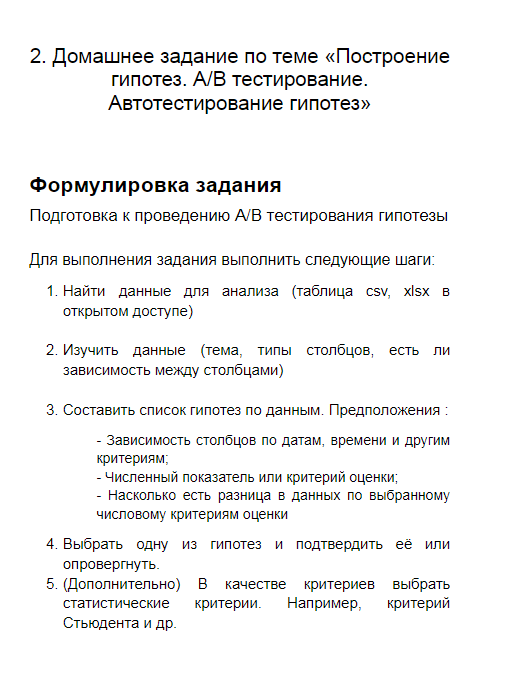

In [ ]:
# Сохранить из google colab или в google colab
from google.colab import files, drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.stats.api as sms
from math import ceil

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Data Frame
df = pd.read_csv('/content/drive/MyDrive/dataset_task2.csv', sep=',')

Содержит id пользователя, время получения доступа к странице, старая страница/новая страница, принадлежность к группе, конверсия. 2 варианта страницы для привлечения новых покупателей

In [ ]:
df.head(10)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,experimental,new_page,0
3,853541,2017-01-08 18:28:03.143765,experimental,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
5,936923,2017-01-10 15:20:49.083499,control,old_page,0
6,679687,2017-01-19 03:26:46.940749,experimental,new_page,1
7,719014,2017-01-17 01:48:29.539573,control,old_page,0
8,817355,2017-01-04 17:58:08.979471,experimental,new_page,1
9,839785,2017-01-15 18:11:06.610965,experimental,new_page,1


In [ ]:
df.tail(10)

,user_id,timestamp,group,landing_page,converted
294468,643562,2017-01-02 19:20:05.460595,experimental,new_page,0
294469,755438,2017-01-18 17:35:06.149568,control,old_page,0
294470,908354,2017-01-11 02:42:21.195145,control,old_page,0
294471,718310,2017-01-21 22:44:20.378320,control,old_page,0
294472,822004,2017-01-04 03:36:46.071379,experimental,new_page,0
294473,751197,2017-01-03 22:28:38.630509,control,old_page,0
294474,945152,2017-01-12 00:51:57.078372,control,old_page,0
294475,734608,2017-01-22 11:45:03.439544,control,old_page,0
294476,697314,2017-01-15 01:20:28.957438,control,old_page,0
294477,715931,2017-01-16 12:40:24.467417,experimental,new_page,0


Работа с датасетом

Сколько столбцов и сколько строк в сохраненном DataFrame

In [ ]:
count = df.shape #кортеж из количества строк и столбцов
print(f'количество строк - {count[0]}, количество столбцов - {count[1]}')

количество строк - 286690, количество столбцов - 5


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 286690 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       286690 non-null  int64 
 1   timestamp     286690 non-null  object
 2   group         286690 non-null  object
 3   landing_page  286690 non-null  object
 4   converted     286690 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 13.1+ MB


In [ ]:
# Пользователи с мульти сессиями
session_counts = df['user_id'].value_counts(ascending = False)
multi_users = session_counts[session_counts > 1].count()

# Удаляем пользователей с мульти сессиями
users_to_drop = session_counts[session_counts > 1].index

df = df[~ df['user_id'].isin(users_to_drop)]

In [ ]:
# Выборка контрольной группы и экспериментальной группы по 5000
control_sample = df[df['group'] == 'control'].sample(n = 5000, random_state = 12)
experimental_sample = df[df['group'] == 'experimental'].sample(n = 5000, random_state = 12)
ab_test = pd.concat([control_sample, experimental_sample], axis=0)
ab_test.reset_index(drop=True, inplace=True)
# Определение функции для стандартного отклонения и стандартной ошибки
std_dev = lambda x : np.std(x, ddof = 0)
std_error = lambda x : stats.sem(x, ddof = 0)
conversion_rate = ab_test.groupby('group')['converted'].agg([np.mean, std_dev, std_error])
conversion_rate.columns = ['conversion_rate', 'std_deviation', 'std_error']
conversion_rate

,conversion_rate,std_deviation,std_error
group,,,
control,0.1144,0.318296,0.004501
experimental,0.1218,0.327055,0.004625


In [ ]:
import numpy as np
from google.colab import autoviz

def value_plot(df, y, sort_ascending=False, figscale=1):
  from matplotlib import pyplot as plt
  figsize = (8 * figscale, 4 * figscale)
  if sort_ascending:
    df = df.sort_values(y).reset_index(drop=True)
  _, ax = plt.subplots(figsize=figsize)
  df[y].plot(kind='line')
  plt.title(y)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(conversion_rate, *['conversion_rate'], **{})
chart

In [63]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

control_results = ab_test[ab_test['group'] == 'control']['converted']
experimental_results = ab_test[ab_test['group'] == 'experimental']['converted']


num_control = control_results.count()
num_experimental = experimental_results.count()
successes = [control_results.sum(), experimental_results.sum()]
nobs = [num_control, num_experimental]

z_stat, pval = proportions_ztest(successes, nobs = nobs)
(lower_con, lower_exp), (upper_con, upper_exp) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'Z-оценка - {z_stat:.2f}')
print(f'P-Value - {pval:.3f}')
print(f'CI 95%  для контрольной группы - [{lower_con:.3f}, {upper_con:.3f}]')
print(f'CI 95% для экспериментальной группы - [{lower_exp:.3f}, {upper_exp:.3f}]')

Z-оценка - -1.15
P-Value - 0.252
CI 95%  для контрольной группы - [0.106, 0.123]
CI 95% для экспериментальной группы - [0.113, 0.131]


P-value для результатов A/B-тестирования равно 0,252. Если установить уровень значимости на уровне 0,05 (по стандарту), то возможно использовать нулевую гипотезу при p-value=0,252. Т.е. наблюдаемые результаты были получены случайно и не являются статистически значимыми, чтобы говорить о том, что страница экспериментальной группы работает лучше.